## Outline:
1. Explore dataset
    - Missing or null values
    - Distributions
    - Summary statistics
3. Multicollinearity
    - Correlation matrix
    - VIF
4. Categorical variable - encoding
5. Outlier analysis
5. Model building
    - Split dataset into train and test set
    - Define and fit the model
    - Explore relationship
        - Different variables
        - Interaction terms
    - Model summary
        - Summary statistics
    - Model adequacy checking
        - Residual plots
        - Normal probability plot
    - Outliers
    - Collinearity check
10. Define final regression equation
    - Which may be the best model?
14. Conclusion

---

Check out the [dataset on Kaggle](https://www.kaggle.com/datasets/aungpyaeap/fish-market)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

#### Styles

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
df = pd.read_csv(r'C:\Users\chris\OneDrive\Documents\Personal Projects\Fish\Fish.csv')

# 1. Explore the dataset

In [4]:
print(df.columns)
print(df.shape)

Index(['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height',
       'Width'],
      dtype='object')
(159, 7)


#### Column descriptions
Weight - weight of fish in grams <br>
Length1 - vertical length in cm<br>
Length2 - Diagonal length in cm<br>
Length3 - Cross length in cm<br>
Height - height in cm<br>
Width - Diagonal width in cm

In [5]:
df = df.rename({'Length1':'Vertical_Length', 'Length2':'Diagonal_Length', 'Length3':'Cross_Length'}, axis='columns')

In [6]:
# separate into category and numerical columns
df_cat = df[['Species']]
df_num = df.select_dtypes(include='number')

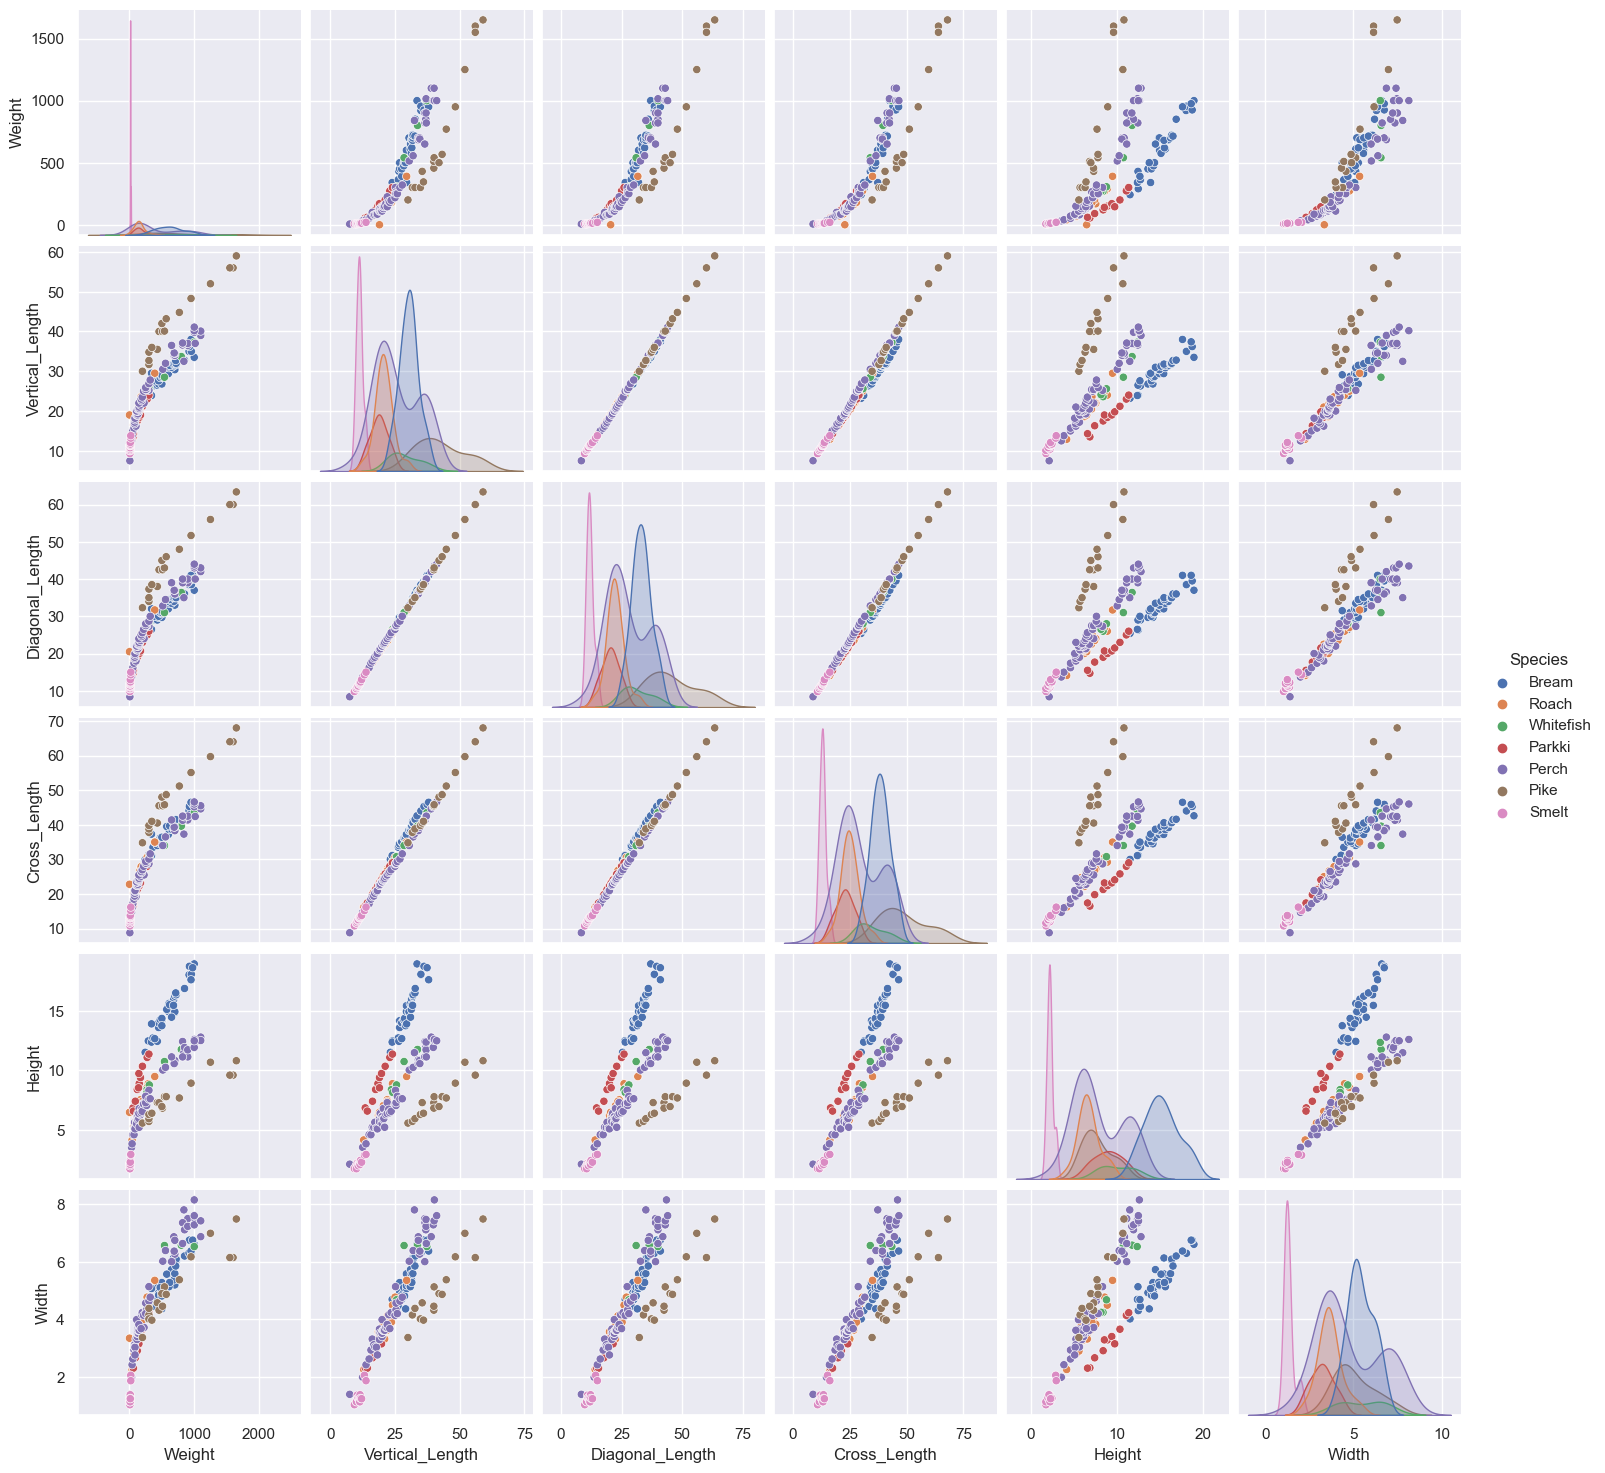

In [7]:
sns.pairplot(df, kind="scatter", hue='Species')
plt.show()

This **correlogram** (Scatter pplot matrix) allows us to see that a linear relationship may be appropriate for this dataset (although it does appear that a nonlinear model might be better), but for the sake of this example, we will continue with the linear assumption.<br>
Any regression model that is linear in the parameters is a linear regression model, regardless of the shape that it may generate (Cite: Montgomery textbook).

This means that the weight of a fish ($y$) can be computed using a linear combination of its different length measurements given the function:<br>
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5
$$

with $\beta_0$ representing the constant term.<br>
Now, we will learn the best values for our $\beta$s from the data, which is where the process for training the model begins. A trained model is a model where the $\beta$ values have been decided. A model with this parameters pre built into the formula is what constitutes a parameteric model. In other words, we fix the formula of the training function before the training.

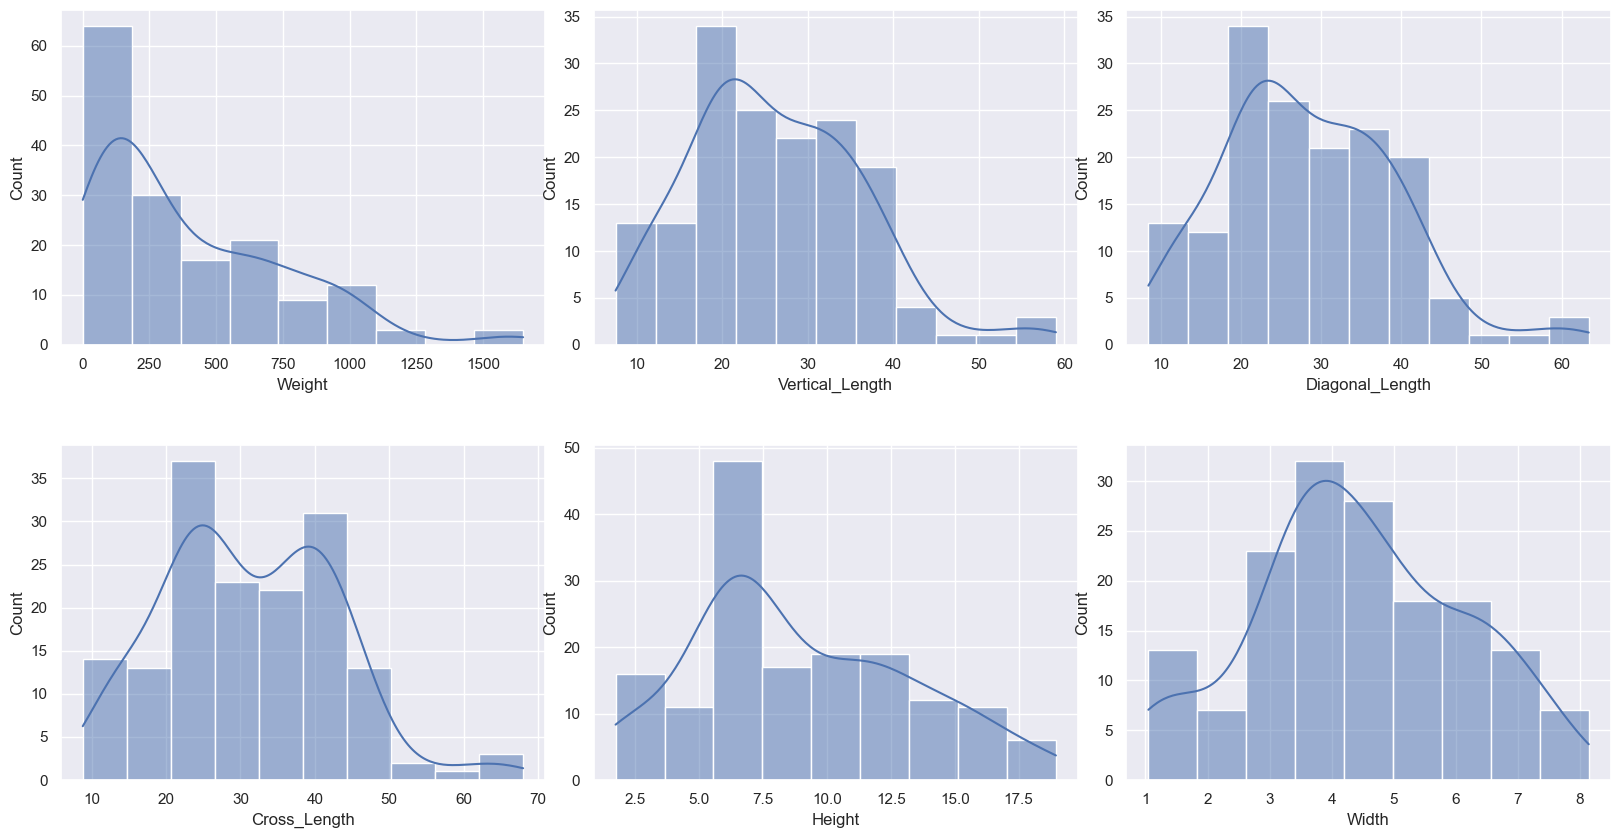

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

axes = axes.ravel()

for i, col in enumerate(df_num):
    sns.histplot(data = df[col], ax=axes[i], kde=True)
plt.show()

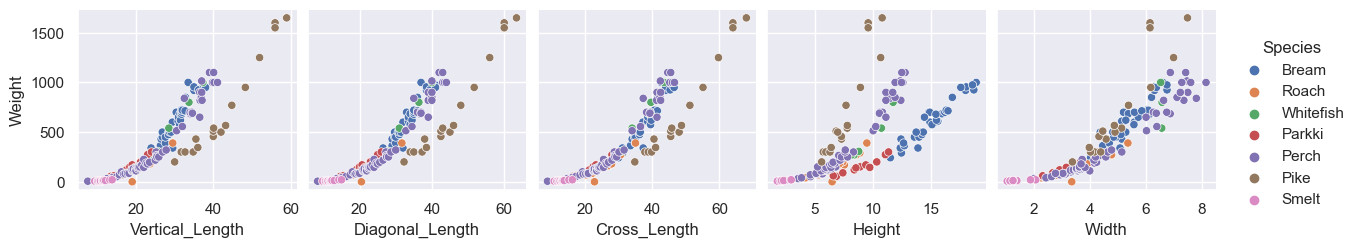

In [9]:
sns.pairplot(df, 
             x_vars=['Vertical_Length', 'Diagonal_Length', 'Cross_Length', 'Height', 'Width'],
             y_vars=['Weight'], hue='Species')
plt.show()

In [10]:
null_sum = df.isna().sum()
print(null_sum)

Species            0
Weight             0
Vertical_Length    0
Diagonal_Length    0
Cross_Length       0
Height             0
Width              0
dtype: int64


**Summary Statistics**

In [11]:
print(len(df))
df.describe()

159


,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


**Notes**
- Notice there are some values where the weight is equal to zero, which is impossible, so it may be an input error and could possibly remove those values
- I should maybe explore each category of species to see if any might be out of the ordinary there

In [12]:
species = df['Species'].value_counts()
species

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

In [13]:
# Weight cannot be 0g, so should look at those values
zeros = df[df['Weight'] == 0]
zeros

,Species,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


This fish cannot possibly weigh 0g, so we will assume for our example that maybe the value was input in error, and will delete this row

In [14]:
# high values - Pike
df[142:145]

,Species,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
142,Pike,1600.0,56.0,60.0,64.0,9.600,6.144
143,Pike,1550.0,56.0,60.0,64.0,9.600,6.144
144,Pike,1650.0,59.0,63.4,68.0,10.812,7.480


These values seem pretty high compared to the rest of the Pike weights, but I have no way to investigate if the data were entered incorrectly, or some other error occurred, so we will assume they are valid data and keep them in the model, until we do further outlier analysis.

In [15]:
# new df with bad value removed and view summary statistics
df1 = df[df['Weight'] != 0]
df1.describe()

,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,400.847468,26.293038,28.465823,31.280380,8.986790,4.424232
std,357.697796,10.011427,10.731707,11.627605,4.295191,1.689010
min,5.900000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,121.250000,19.150000,21.000000,23.200000,5.940600,3.398650
50%,281.500000,25.300000,27.400000,29.700000,7.789000,4.277050
75%,650.000000,32.700000,35.750000,39.675000,12.371850,5.586750
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


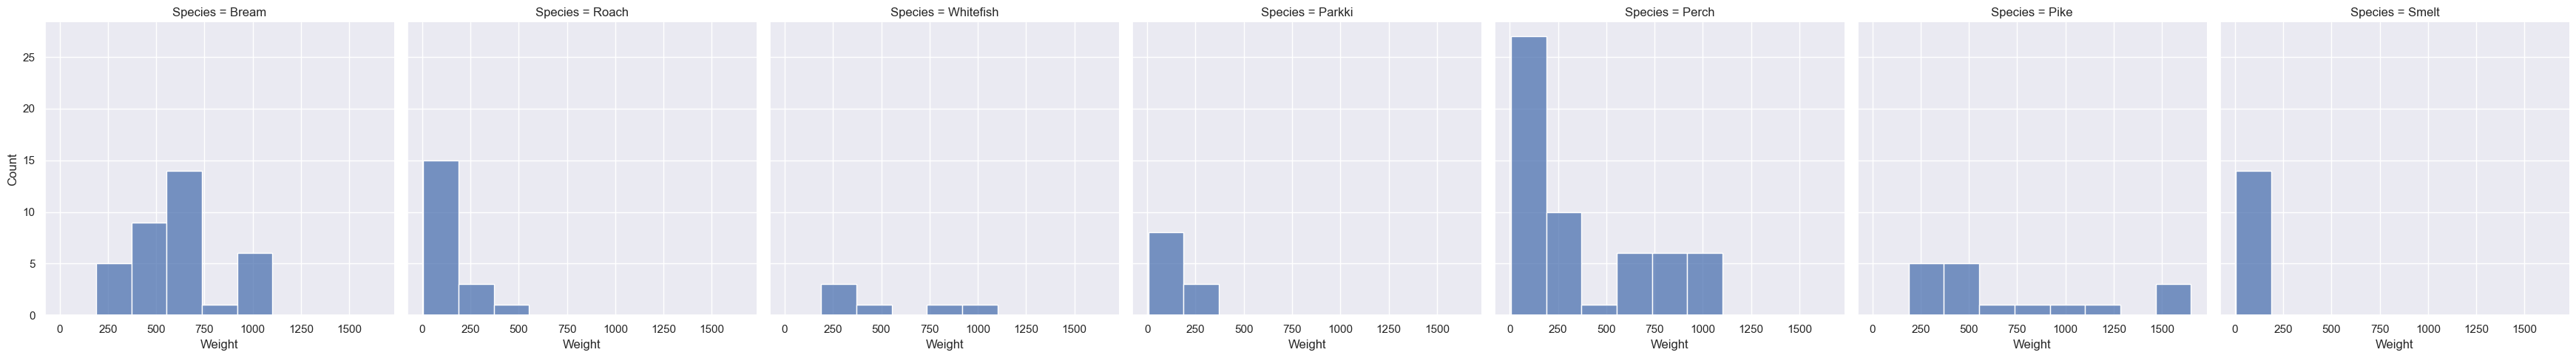

In [16]:
# trying a view of the counts by species for weight
sns.displot(
    data=df1,
    x='Weight',
    col='Species',
    kind='hist')
plt.show()

# 2. Multicollinearity

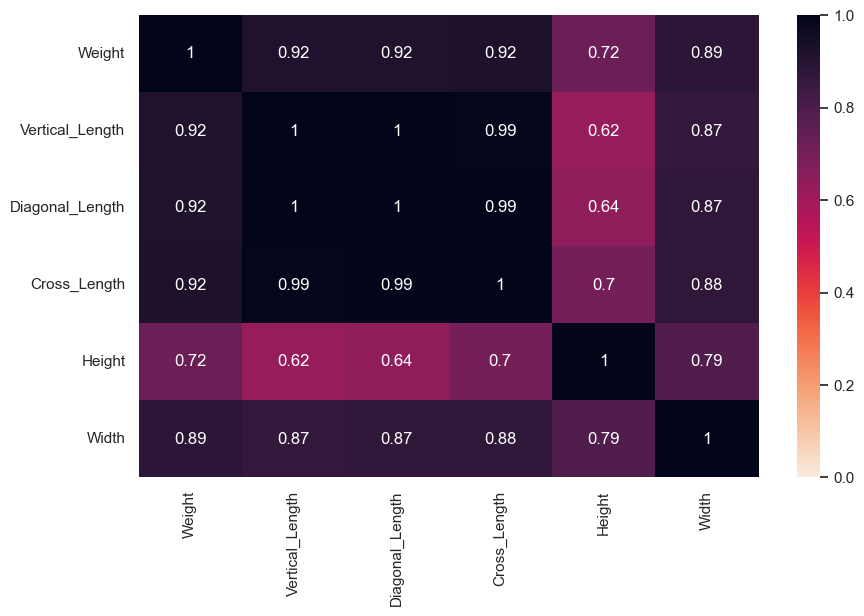

In [17]:
# make figure a bit bigger
plt.figure(figsize=(10,6))

# correlation heatmap
sns.heatmap(df1.corr(), annot=True, vmin=0, vmax=1, cmap="rocket_r")
plt.show()

- Note that all are pretty highly correlated, especially the length variables, height has the least issues with this

In [18]:
# VIF
df1_num = df1.select_dtypes(include='number')
df1_vif = df1_num.drop(columns=['Weight'])

vif_data = pd.DataFrame()

vif_data['Column'] = df1_vif.columns

vif_data['VIF'] = [vif(df1_vif.values, i) for i in range(len(df1_vif.columns))]

vif_data.sort_values(by='VIF', ascending=True)

,Column,VIF
3,Height,76.053658
4,Width,92.653797
2,Cross_Length,3382.291295
0,Vertical_Length,12749.616323
1,Diagonal_Length,16580.478064


- All of these have a very high VIF if using the rule of thumb;
    - 1 = not correlated
    - Between 1 and 5 = moderately correlated
    - Greater than 5 = highly correlated
- Clearly these are very large, which indicates high multicollinearity
- Although how large is subjective, and these VIF values may not be a cause for concern because of nonlinearity

In [19]:
df_s = df1.drop(columns=['Species'])

In [20]:
df_s

,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936
155,13.4,11.7,12.4,13.5,2.4300,1.2690
156,12.2,12.1,13.0,13.8,2.2770,1.2558
157,19.7,13.2,14.3,15.2,2.8728,2.0672


In [21]:
# looking at model without categorical variables
X = df_s.iloc[:, 1:13]
y = df_s[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# Parameters of the model
print('Model intercept: ', model.intercept_)
print('Model coefficients: ', model.coef_)
print('Model score: ', model.score(X, y))

Model intercept:  [-508.1266398]
Model coefficients:  [[ 64.47213583 -15.95788928 -20.91011286  22.63479042  26.33134356]]
Model score:  0.8845203299676552


In [24]:
# predicting weights from the test set
y_hat = model.predict(X_test)

In [25]:
# Analyzing R2 of model from training set and predictions
r2_score(y_test, y_hat)

0.9019952820001658

In [26]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 12859.471
RMSE: 113.400
MAE: 9.451


In [27]:
# Cross validation
cross_val_score_train = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(cross_val_score_train)
print(cross_val_score_train.mean())

[0.83360732 0.90962575 0.86149383 0.89453864 0.91354366 0.83375628
 0.80927676 0.82069684 0.45719591 0.82149897]
0.815523396194177


# 3. Categorical variables

In [28]:
# categorical encoding
df2 = pd.get_dummies(df1)
df2

,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936,0,0,0,0,0,1,0
155,13.4,11.7,12.4,13.5,2.4300,1.2690,0,0,0,0,0,1,0
156,12.2,12.1,13.0,13.8,2.2770,1.2558,0,0,0,0,0,1,0
157,19.7,13.2,14.3,15.2,2.8728,2.0672,0,0,0,0,0,1,0


In [29]:
df3 = df2.drop(columns=['Species_Bream'])

In [30]:
X = df3.iloc[:, 1:12]
y = df3[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [32]:
# Parameters of the model
print('Model intercept: ', model.intercept_)
print('Model coefficients: ', model.coef_)
print('Model score: ', model.score(X, y))

Model intercept:  [-785.67562956]
Model coefficients:  [[ -63.17797578   71.70850333   27.81978955  -11.52939024    6.42359181
   133.76631624   34.38721174 -362.58082738    9.46492511  306.4493073
    63.20534515]]
Model score:  0.9329499697782535


In [33]:
# predicting weights from the test set
y_hat = model.predict(X_test)

In [34]:
r2_score(y_test, y_hat)

0.9482451798572478

In [35]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 6790.893
RMSE: 82.407
MAE: 7.909


In [36]:
cross_val_score_train = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(cross_val_score_train)
print(cross_val_score_train.mean())

[0.91333352 0.96324695 0.93654314 0.9341261  0.86007924 0.9247442
 0.82266236 0.88844178 0.84039499 0.60139132]
0.8684963615355723


In [37]:
X_sm = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     122.8
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.74e-55
Time:                        19:56:49   Log-Likelihood:                -705.36
No. Observations:                 118   AIC:                             1435.
Df Residuals:                     106   BIC:                             1468.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -785.6756    162.385     -4.838      0.000   -1107.619    -463.732
Vertical_Length     -63.1780     46.329     -1.364      0.176    -155.030      28.674
Diagonal_Length      71.7085     57.073      1.256      0.212     -41.444     184.861
Cross_Length         27.8198     36.164      0.769      0.443     -43.879      99.519
Height              -11.5294     17.413     -0.662      0.509     -46.051      22.993
Width                 6.4236     30.262      0.212      0.832     -53.575      66.422
Species_Parkki      133.7663     97.319      1.375      0.172     -59.177     326.710
Species_Perch        34.3872    155.181      0.222      0.825    -273.274     342.049
Species_Pike       -362.5808    177.545     -2.042      0.044    -714.581     -10.580
Species_Roach         9.4649    118.958      0.080      0.937    -226.381     245.311
Species_Smelt       306.4493    155.869      1.966      0.052      -2.575     615.474
Species_Whitefish    63.2053    125.793      0.502      0.616    -186.192     312.603
==============================================================================
Omnibus:                       24.525   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.917
Skew:                           0.953   Prob(JB):                     2.15e-09
Kurtosis:                       5.118   Cond. No.                     2.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 4. Outlier analysis

In [38]:
# separate into category and numerical columns
df1_cat = df1[['Species']]
df1_num = df1.select_dtypes(include='number')

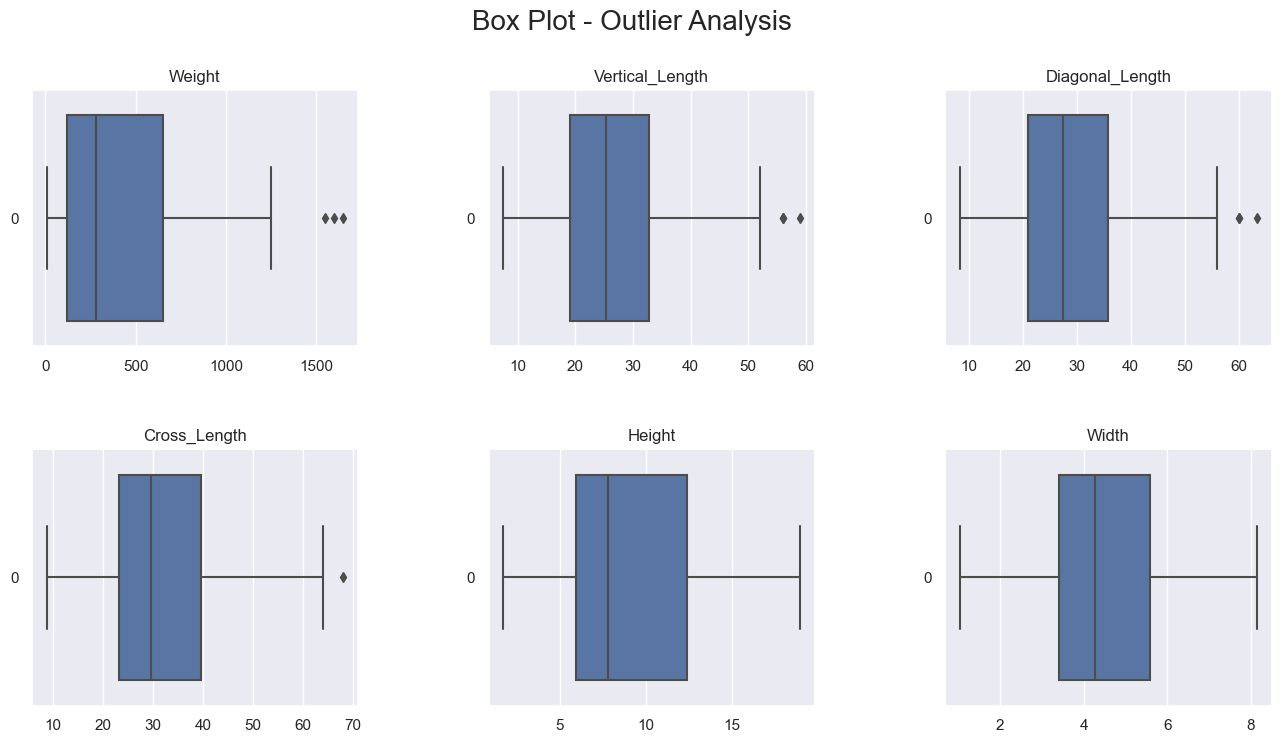

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()
fig.subplots_adjust(wspace=0.4, hspace=0.4)
fig.suptitle('Box Plot - Outlier Analysis', fontsize=20)

for i, col in enumerate(df1_num):
    box=sns.boxplot(data=df1_num[col], ax=axes[i], orient='h')
    axes[i].set_title(col)
    
plt.show()

Note: It seems there are three values that might be a cause for concern, so we will fit the model with and without them, and compare results

# 5. Model building
- Then we will fit the full model to use for comparison when we explore further
    - SKLearn
    - Statsmodels

## Split into training and test sets

In [40]:
# we will split using the data frame with the dummy variables
# Note: this data frame is the full data frame - no variables or outliers yet removed
X = df3.iloc[:, 1:13]
y = df3[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [41]:
print('X_train: ', np.shape(X_train))
print('y_train: ', np.shape(y_train))

X_train:  (118, 11)
y_train:  (118, 1)


## Define and fit the model

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [43]:
# Parameters of the model
print('Model intercept: ', model.intercept_)
print('Model coefficients: ', model.coef_)
print('Model score: ', model.score(X, y))

Model intercept:  [-785.67562956]
Model coefficients:  [[ -63.17797578   71.70850333   27.81978955  -11.52939024    6.42359181
   133.76631624   34.38721174 -362.58082738    9.46492511  306.4493073
    63.20534515]]
Model score:  0.9329499697782535


In [44]:
# predicting weights from the test set
y_hat = model.predict(X_test)

In [45]:
# Analyzing success of model from training set and predictions
r2_score(y_test, y_hat)

0.9482451798572478

In [46]:
cross_val_score_train = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(cross_val_score_train)
print(cross_val_score_train.mean())

[0.91333352 0.96324695 0.93654314 0.9341261  0.86007924 0.9247442
 0.82266236 0.88844178 0.84039499 0.60139132]
0.8684963615355723


In [47]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 6790.893
RMSE: 82.407
MAE: 7.909


In [48]:
# using the original model (full), I will look at the statsmodels package results

## Summary

In [49]:
X_sm = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     122.8
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           4.74e-55
Time:                        19:57:31   Log-Likelihood:                -705.36
No. Observations:                 118   AIC:                             1435.
Df Residuals:                     106   BIC:                             1468.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -785.6756    162.385     -4.838      0.000   -1107.619    -463.732
Vertical_Length     -63.1780     46.329     -1.364      0.176    -155.030      28.674
Diagonal_Length      71.7085     57.073      1.256      0.212     -41.444     184.861
Cross_Length         27.8198     36.164      0.769      0.443     -43.879      99.519
Height              -11.5294     17.413     -0.662      0.509     -46.051      22.993
Width                 6.4236     30.262      0.212      0.832     -53.575      66.422
Species_Parkki      133.7663     97.319      1.375      0.172     -59.177     326.710
Species_Perch        34.3872    155.181      0.222      0.825    -273.274     342.049
Species_Pike       -362.5808    177.545     -2.042      0.044    -714.581     -10.580
Species_Roach         9.4649    118.958      0.080      0.937    -226.381     245.311
Species_Smelt       306.4493    155.869      1.966      0.052      -2.575     615.474
Species_Whitefish    63.2053    125.793      0.502      0.616    -186.192     312.603
==============================================================================
Omnibus:                       24.525   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.917
Skew:                           0.953   Prob(JB):                     2.15e-09
Kurtosis:                       5.118   Cond. No.                     2.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual Analysis

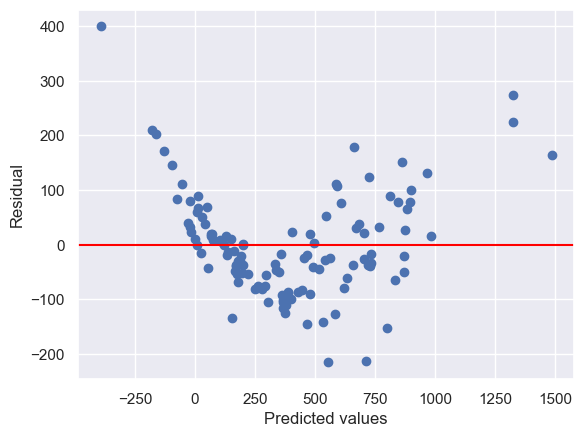

In [50]:
# using full model
residuals = sm_model.resid

plt.scatter(sm_model.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

This indicates some potential nonlinearity in the data. We can experiment by adding interaction terms.

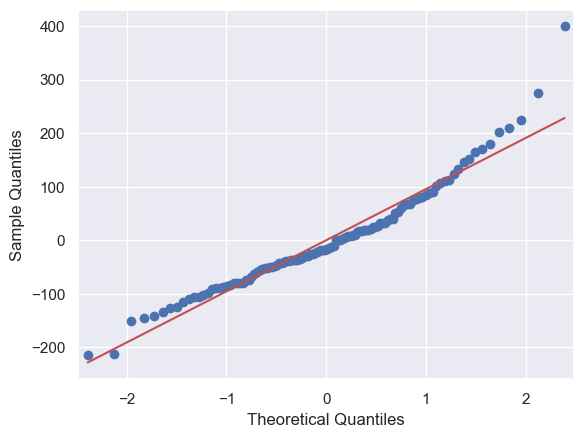

In [51]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Clearly, it mostly follows the line except for three points at the top, which one may or may not remove, depending on preference

## Outliers

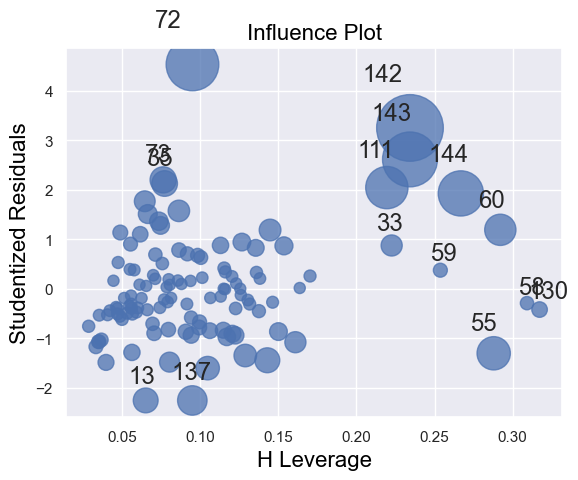

In [52]:
# influence plot
fig = sm.graphics.influence_plot(sm_model, criterion='cooks')
plt.show()

In [53]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model.get_influence().cooks_distance[0]

n = len(X_train)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X_train.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.03389830508474576
Int64Index([137, 142, 111, 143, 144, 60, 55, 72], dtype='int64') 
 [0.04262362 0.24729002 0.09532826 0.16539705 0.11011024 0.04889406
 0.05648581 0.15169978]


Clearly, there are some points that seem to have a high amount of leverage or influence, such as 142, 143, 144, and 72.

# 6. Explore relationships
- Test with different variables
- Test with possible interaction terms


---

| Model  | $R^2$ | Adj. $R^2$ | F-Statistic | RMSE | Notes |
| ------ | ----- | ---------- | ----------- | ---- | :--- |
| Full | 0.936 | 0.931 | 193.6 | 90.652| Lots of issues with the variables |
| Vertical Length | 0.93 | 0.927 | 220.9 | 90.652 | Width and height p values are still high |
| Diagonal Length | 0.933 | 0.929 | 230.0 | 87.159 | Same |
| Cross Length | 0.934 | 0.930 | 231.6 | 87.144 | Same |
| Int - Vertical | 0.973 | 0.971 | 526.4 | 63.345 | Good p values if a = 0.05, residuals look better than full |
| Int - Diagonal | 0.973 | 0.971 | 529.1 | 63.318 | Same |
| Int - Cross | 0.973 | 0.971 | 528.7 | 62.310 | High p-value for width |
| ln(y) | 0.99 | 0.99 | Good | 0.088 | Good p values for everything, and random looking residuals |

In [54]:
# do again, but with only one length column
X = df3.drop(columns=['Weight', 'Vertical_Length', 'Diagonal_Length'])
y = df3[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [56]:
y_hat = lr.predict(X_test)

In [57]:
r2_score(y_test, y_hat)

0.943429129558069

In [58]:
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

MSE: 7594.113
RMSE: 87.144
MAE: 8.016


In [59]:
# testing with different parameters
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()

sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     231.6
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           1.63e-82
Time:                        19:57:48   Log-Likelihood:                -938.31
No. Observations:                 158   AIC:                             1897.
Df Residuals:                     148   BIC:                             1927.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -880.5453     83.361    -10.563      0.000   -1045.278    -715.813
Cross_Length         36.1375      3.621      9.980      0.000      28.982      43.293
Height                9.0784     13.107      0.693      0.490     -16.822      34.979
Width                -4.6968     24.060     -0.195      0.845     -52.242      42.849
Species_Parkki      145.5203     47.083      3.091      0.002      52.479     238.562
Species_Perch       145.0644     78.814      1.841      0.068     -10.682     300.811
Species_Pike       -207.4204    118.401     -1.752      0.082    -441.396      26.555
Species_Roach        90.4909     74.854      1.209      0.229     -57.430     238.412
Species_Smelt       406.8827     87.053      4.674      0.000     234.855     578.910
Species_Whitefish   106.1028     76.699      1.383      0.169     -45.464     257.669
==============================================================================
Omnibus:                       40.058   Durbin-Watson:                   0.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.675
Skew:                           1.112   Prob(JB):                     2.49e-19
Kurtosis:                       5.840   Cond. No.                         936.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interaction terms

Due to the residuals looking nonlinear, perhaps a transformation would work well for this data. Thinking about how one may measure weight, perhaps volume might be a good indicator. Volume = Length x Width x Height

> Lets use the interaction term with vertical length for analysis

In [60]:
df3['Volume'] = df3['Height']*df3['Width']*df3['Vertical_Length']

In [61]:
X = df3.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
y = df3[['Weight']]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9701085869761354
Adj r2:  0.9558745807742952
MSE: 4012.644
RMSE: 63.345
MAE: 6.850


In [63]:
# testing with different parameters - interaction term
X_sm = sm.add_constant(X)
sm_model1 = sm.OLS(y, X_sm).fit()

sm_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     526.4
Date:                Wed, 22 Feb 2023   Prob (F-statistic):          9.95e-110
Time:                        19:57:59   Log-Likelihood:                -867.83
No. Observations:                 158   AIC:                             1758.
Df Residuals:                     147   BIC:                             1791.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                34.0327     74.987      0.454      0.651    -114.159     182.224
Vertical_Length      26.5681      2.631     10.100      0.000      21.370      31.767
Height              -45.4817      9.222     -4.932      0.000     -63.706     -27.257
Width               -35.6302     15.586     -2.286      0.024     -66.432      -4.828
Species_Parkki       -4.3771     31.126     -0.141      0.888     -65.889      57.134
Species_Perch      -146.4913     53.757     -2.725      0.007    -252.728     -40.255
Species_Pike       -391.2893     79.991     -4.892      0.000    -549.370    -233.208
Species_Roach      -131.0018     50.313     -2.604      0.010    -230.431     -31.572
Species_Smelt      -182.7097     66.413     -2.751      0.007    -313.956     -51.463
Species_Whitefish   -55.5748     50.516     -1.100      0.273    -155.406      44.257
Volume                0.2542      0.017     15.094      0.000       0.221       0.288
==============================================================================
Omnibus:                       36.382   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.827
Skew:                           0.628   Prob(JB):                     2.46e-44
Kurtosis:                       8.378   Cond. No.                     5.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

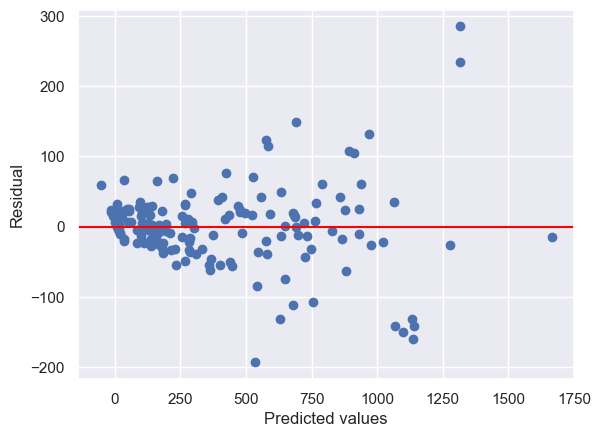

In [64]:
residuals = sm_model1.resid

plt.scatter(sm_model1.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

Adding the interacting term seems to have helped it look more random. But I don't like the funnel shape that is produced. We may need to perform a transformation to make it more linear.

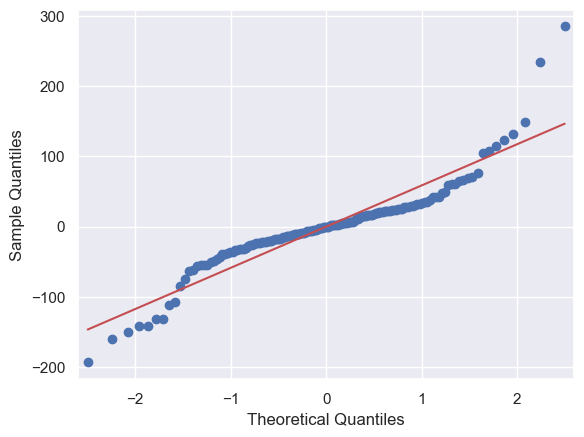

In [65]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Still some questionable points at the top, but the rest fall pretty close to the line, but not entirely normally distributed.

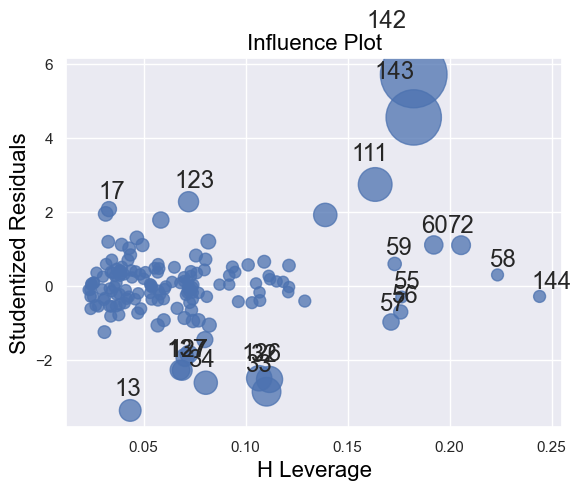

In [66]:
# influence plot
fig = sm.graphics.influence_plot(sm_model1, criterion='cooks')
plt.show()

In [67]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model1.get_influence().cooks_distance[0]

n = len(X)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.02531645569620253
Int64Index([13, 29, 32, 33, 34, 60, 72, 111, 123, 126, 127, 137, 142, 143], dtype='int64') 
 [0.04353014 0.05292537 0.07018666 0.08754108 0.05220421 0.02642313
 0.0283841  0.12750454 0.03541461 0.06505045 0.03392408 0.03301345
 0.54359171 0.3697363 ]


Here, it is clear that points 142, 143, and 144 have a lot of leverage and influence. Let's try removing them.

In [68]:
# outlier removal and variable selection
df3 = df3.drop([142, 143, 144])
len(df3)

155

In [69]:
X = df3.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
y = df3[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9858885592047293
Adj r2:  0.9788328388070939
MSE: 1577.113
RMSE: 39.713
MAE: 5.347


In [70]:
X_sm = sm.add_constant(X)
sm_model2 = sm.OLS(y, X_sm).fit()

sm_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     717.4
Date:                Wed, 22 Feb 2023   Prob (F-statistic):          1.73e-117
Time:                        19:58:28   Log-Likelihood:                -808.66
No. Observations:                 155   AIC:                             1639.
Df Residuals:                     144   BIC:                             1673.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -86.8901     60.753     -1.430      0.155    -206.972      33.192
Vertical_Length      13.2497      2.399      5.524      0.000       8.509      17.991
Height              -19.9179      7.835     -2.542      0.012     -35.405      -4.431
Width                 4.3251     12.450      0.347      0.729     -20.284      28.934
Species_Parkki       26.3788     24.053      1.097      0.275     -21.165      73.922
Species_Perch       -32.4094     43.748     -0.741      0.460    -118.880      54.061
Species_Pike       -111.5935     68.524     -1.629      0.106    -247.036      23.849
Species_Roach       -34.9404     40.406     -0.865      0.389    -114.807      44.926
Species_Smelt       -20.7888     55.105     -0.377      0.707    -129.708      88.131
Species_Whitefish    27.1481     40.079      0.677      0.499     -52.070     106.367
Volume                0.2234      0.014     16.086      0.000       0.196       0.251
==============================================================================
Omnibus:                       18.950   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.740
Skew:                          -0.145   Prob(JB):                     7.98e-18
Kurtosis:                       6.480   Cond. No.                     5.98e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

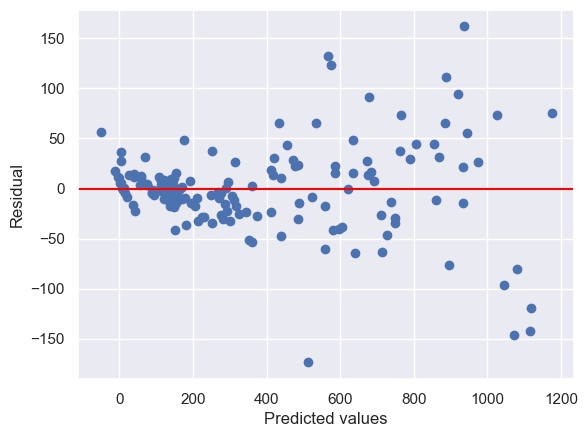

In [71]:
# using model
residuals = sm_model2.resid

plt.scatter(sm_model2.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

 From the residual plot, it still produces a funnel shape.

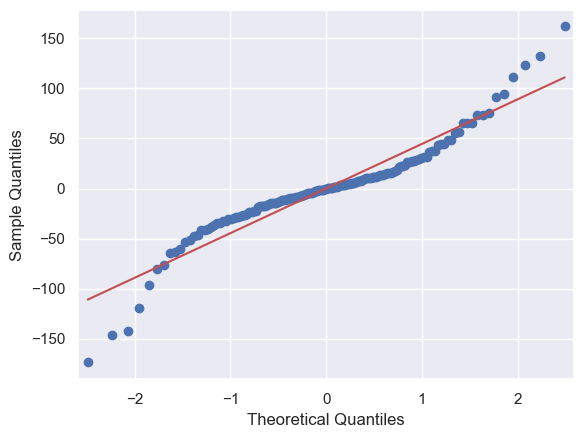

In [72]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

Still, it mostly follows the line except for a few in the tails

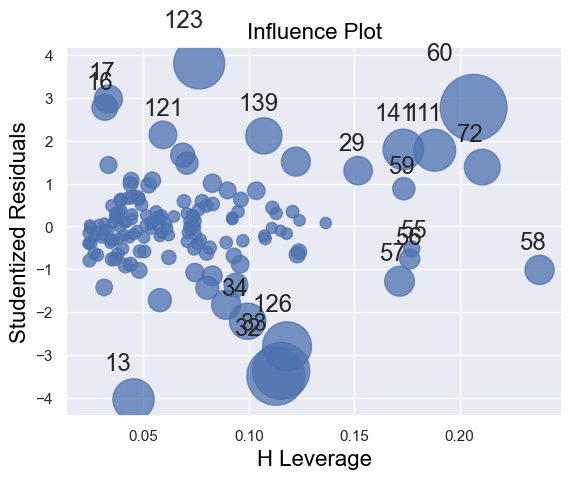

In [73]:
# influence plot
fig = sm.graphics.influence_plot(sm_model2, criterion='cooks')
plt.show()

In [74]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model2.get_influence().cooks_distance[0]

n = len(X)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.025806451612903226
Int64Index([13, 17, 29, 32, 33, 34, 57, 58, 60, 72, 111, 123, 126, 127, 139,
            140, 141],
           dtype='int64') 
 [0.06369678 0.02639529 0.02752491 0.1312434  0.12604294 0.0479478
 0.0307087  0.02927068 0.17399933 0.04632397 0.06571099 0.09972014
 0.09112421 0.02934761 0.04769271 0.02876609 0.06079485]


eval_env: 1


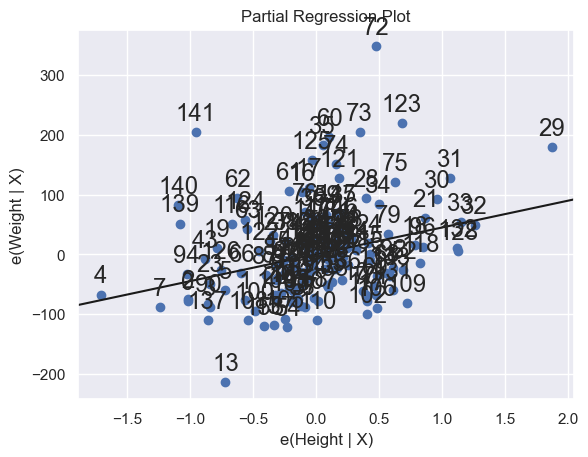

In [77]:
sm.graphics.plot_partregress(
    endog='Weight',
    exog_i = 'Height',
    exog_others=['Width', 'Vertical_Length', 'Diagonal_Length', 'Cross_Length', 'Species_Parkki', 'Species_Perch', 'Species_Pike', 'Species_Roach', 'Species_Whitefish', 'Species_Smelt'],
    data=df3,
    obs_labels=True)
plt.show()

**Partial Regression plot** - a type of diagnostic plot for multilinear regression models, they attempt to show the effect of adding a new variable to an existing model by controlling for the effect of the predictors already in use. They are useful for spotting leverage and influential points.


---

With the funnel shape of the residuals, and the nonlinearity of the response variable, we performed the interaction term, but we may need to do a transformation to make it more linear. I will apply a log transformation of the response variable.<br>

**Log transform**

In [78]:
y = np.log(df3.Weight)

In [79]:
X = df3.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
ln_y = y

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, ln_y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9926637216147842
Adj r2:  0.9889955824221763
MSE: 0.013
RMSE: 0.113
MAE: 0.302


In [81]:
X_sm = sm.add_constant(X)
sm_model3 = sm.OLS(ln_y, X_sm).fit()

sm_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1772.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):          2.29e-145
Time:                        19:59:16   Log-Likelihood:                 112.30
No. Observations:                 155   AIC:                            -202.6
Df Residuals:                     144   BIC:                            -169.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6727      0.160      4.214      0.000       0.357       0.988
Vertical_Length       0.0753      0.006     11.954      0.000       0.063       0.088
Height                0.2226      0.021     10.811      0.000       0.182       0.263
Width                 0.3046      0.033      9.312      0.000       0.240       0.369
Species_Parkki        0.2231      0.063      3.530      0.001       0.098       0.348
Species_Perch         0.4797      0.115      4.174      0.000       0.253       0.707
Species_Pike          0.3767      0.180      2.092      0.038       0.021       0.733
Species_Roach         0.4516      0.106      4.253      0.000       0.242       0.661
Species_Smelt        -0.0395      0.145     -0.273      0.785      -0.326       0.247
Species_Whitefish     0.4666      0.105      4.431      0.000       0.258       0.675
Volume               -0.0006   3.65e-05    -17.066      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      113.540   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1602.015
Skew:                          -2.392   Prob(JB):                         0.00
Kurtosis:                      18.005   Cond. No.                     5.98e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

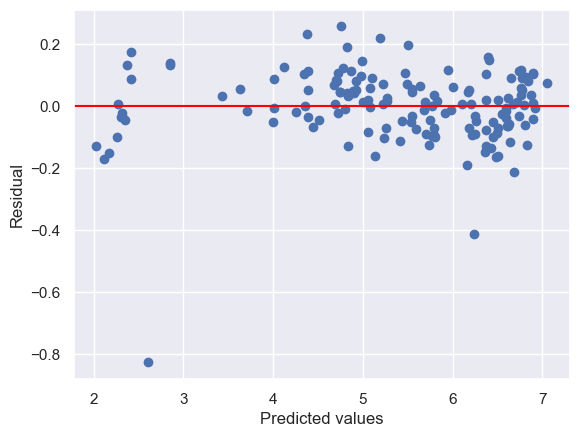

In [82]:
# using model
residuals = sm_model3.resid

plt.scatter(sm_model3.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

That looks a lot better, however it does appear that there may a few outliers that we missed before according to these plots.

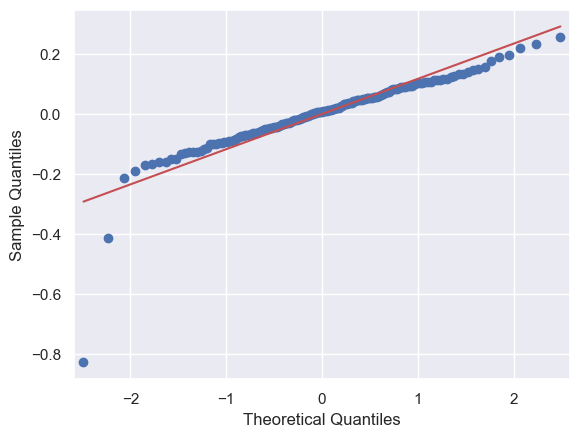

In [83]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

In [84]:
# Cook's distance - rule of thumb, drop observations with distance over 4/n
lm_cooks = sm_model3.get_influence().cooks_distance[0]

n = len(X)

# calculate d
d = 4/n
print('Criticial distance: ', d)

out_d = lm_cooks > d

print(X.index[out_d], "\n", lm_cooks[out_d])

Criticial distance:  0.025806451612903226
Int64Index([13, 58, 72, 117, 129], dtype='int64') 
 [0.0517299  0.04511071 1.42329489 0.02651304 0.03879586]


In [120]:
# remove point 13 and 72
# outlier removal and variable selection
df4 = df3.drop([13, 72])
len(df4)

153

In [86]:
y = np.log(df4.Weight)
X = df4.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
ln_y = y

X_train, X_test, y_train, y_test = train_test_split(X, ln_y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9889376169433531
Adj r2:  0.9834064254150297
MSE: 0.008
RMSE: 0.088
MAE: 0.272


In [87]:
# cross validation
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
print(scores)
print('R2: ', np.mean(scores))

scores2 = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print(scores2)
print('RMSE: ', math.sqrt(np.mean(abs(scores2))))

[0.99328735 0.99616257 0.99699811 0.99280587 0.99479305]
R2:  0.9948093908684947
[-0.00890102 -0.00966734 -0.00552462 -0.01043415 -0.0089092 ]
RMSE:  0.0932054951192439


In [88]:
X_sm = sm.add_constant(X)
sm_model4 = sm.OLS(ln_y, X_sm).fit()

sm_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3241.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):          3.16e-162
Time:                        19:59:54   Log-Likelihood:                 160.77
No. Observations:                 153   AIC:                            -299.5
Df Residuals:                     142   BIC:                            -266.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1568      0.123      9.410      0.000       0.914       1.400
Vertical_Length       0.0702      0.005     15.187      0.000       0.061       0.079
Height                0.1879      0.015     12.390      0.000       0.158       0.218
Width                 0.2908      0.024     12.280      0.000       0.244       0.338
Species_Parkki        0.1264      0.046      2.720      0.007       0.035       0.218
Species_Perch         0.3398      0.084      4.039      0.000       0.173       0.506
Species_Pike          0.2502      0.131      1.906      0.059      -0.009       0.510
Species_Roach         0.2967      0.078      3.804      0.000       0.143       0.451
Species_Smelt        -0.3742      0.108     -3.450      0.001      -0.589      -0.160
Species_Whitefish     0.3655      0.077      4.758      0.000       0.214       0.517
Volume               -0.0005   2.84e-05    -18.031      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   1.345
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.321
Skew:                           0.212   Prob(JB):                        0.517
Kurtosis:                       2.835   Cond. No.                     6.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

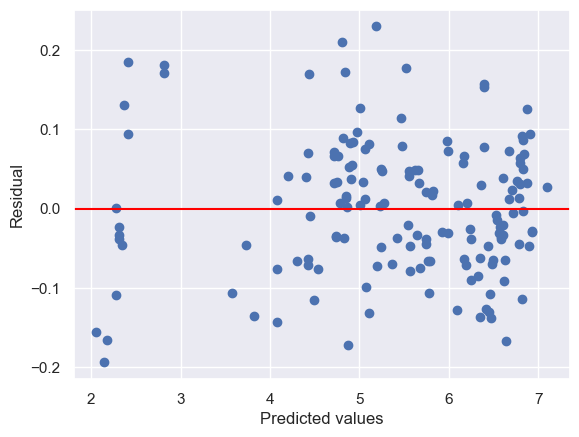

In [89]:
# using model
residuals = sm_model4.resid

plt.scatter(sm_model4.predict(), residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

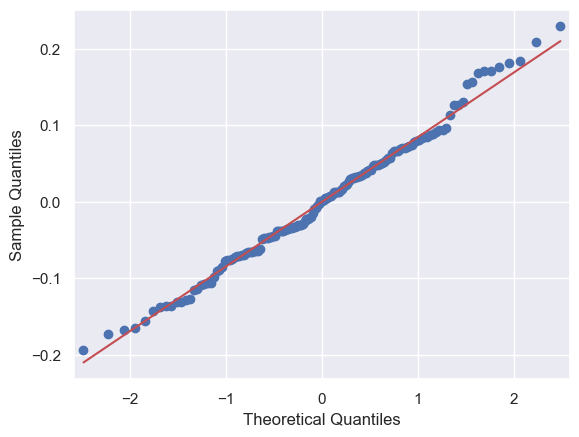

In [90]:
# normal probability plot
pplot = sm.ProbPlot(residuals)
fig = pplot.qqplot(line='s')
plt.show()

These plots look a lot better to me, and I am confident in the model.

In [92]:
# Collinearity check
# VIF
df4 = df4.drop(columns=['Cross_Length', 'Diagonal_Length'])
df4_num = df4.select_dtypes(include='number')
df4_vif = df4_num.drop(columns=['Weight'])

vif_data = pd.DataFrame()

vif_data['Column'] = df4_vif.columns

vif_data['VIF'] = [vif(df4_vif.values, i) for i in range(len(df4_vif.columns))]

vif_data.sort_values(by='VIF', ascending=True)

,Column,VIF
3,Species_Parkki,1.690258
8,Species_Whitefish,2.520930
7,Species_Smelt,2.802845
6,Species_Roach,5.314834
4,Species_Perch,17.437738
5,Species_Pike,18.816907
9,Volume,23.252056
1,Height,102.477664
2,Width,239.855603
0,Vertical_Length,315.910408


These VIF values are much lower than before, however still not great for the majority of the variables.

## 6. Final model

---

The best looking model thus far is the model with the log transformation on the regressor variable, and taking out some influential/leverage points. This model had a low RMSE, and a high adjusted $R^2$, and good p-values for all the provided statistics. Performing cross validation also concluded that it may not be overfit. I will rerun the respective cells below.

In [121]:
y = np.log(df4.Weight)
X = df4.drop(columns=['Weight','Diagonal_Length', 'Cross_Length'])
ln_y = y

X_train, X_test, y_train, y_test = train_test_split(X, ln_y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9889376169433531
Adj r2:  0.9834064254150297
MSE: 0.008
RMSE: 0.088
MAE: 0.272


In [122]:
# cross validation
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
print(scores)
print('R2: ', np.mean(scores))

scores2 = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print(scores2)
print('RMSE: ', math.sqrt(np.mean(abs(scores2))))

[0.99328735 0.99616257 0.99699811 0.99280587 0.99479305]
R2:  0.9948093908684947
[-0.00890102 -0.00966734 -0.00552462 -0.01043415 -0.0089092 ]
RMSE:  0.0932054951192439


In [123]:
X_sm = sm.add_constant(X)
sm_model4 = sm.OLS(ln_y, X_sm).fit()

sm_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3241.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):          3.16e-162
Time:                        20:26:32   Log-Likelihood:                 160.77
No. Observations:                 153   AIC:                            -299.5
Df Residuals:                     142   BIC:                            -266.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1568      0.123      9.410      0.000       0.914       1.400
Vertical_Length       0.0702      0.005     15.187      0.000       0.061       0.079
Height                0.1879      0.015     12.390      0.000       0.158       0.218
Width                 0.2908      0.024     12.280      0.000       0.244       0.338
Species_Parkki        0.1264      0.046      2.720      0.007       0.035       0.218
Species_Perch         0.3398      0.084      4.039      0.000       0.173       0.506
Species_Pike          0.2502      0.131      1.906      0.059      -0.009       0.510
Species_Roach         0.2967      0.078      3.804      0.000       0.143       0.451
Species_Smelt        -0.3742      0.108     -3.450      0.001      -0.589      -0.160
Species_Whitefish     0.3655      0.077      4.758      0.000       0.214       0.517
Volume               -0.0005   2.84e-05    -18.031      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   1.345
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.321
Skew:                           0.212   Prob(JB):                        0.517
Kurtosis:                       2.835   Cond. No.                     6.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As you can see, there are high $R^{2}$ and adj. $R^{2}$ values, as well as a low p-value (using a significance level of 0.05) for the f statistic. This tells us that the sample data provides sufficient evidence to conclude that the regression model fits the data better than the model with no independent variables.<br>
<br>
Another statistic that assesses how well a regression model fits a data set is the root mean square error (RMSE). This metric shows the average distance between the predicted values and the actual values in the data set. The lower the RMSE, the better a given model is able to fit a data set.<br>
<br>
For the Durbin-Watson, this is a test for autocorrelation. A value of 2 indicates zero autocorrelation, our value is below 2, indicating a positive autocorrelation. A **rule of thumb** is that values between 1.5 and 2.5 are relatively normal. Even though our value is 1.345, I would say given the nature of the data, this is pretty close.

#### Random Forest

In [94]:
X = df2.iloc[:, 1:13]
y = df2[['Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [95]:
# Random forest regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

# predictions
y_hat = rf.predict(X_test)

print('R2: ', r2_score(y_test, y_hat))
print("Adj r2: ", 1 - (1-rf.score(X_test, y_test))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))
print("MSE: %.3f" % mean_squared_error(y_test, y_hat))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_hat)))
print("MAE: %.3f" % math.sqrt(mean_absolute_error(y_test, y_hat)))

R2:  0.9618328695427025
Adj r2:  0.9448697004505703
MSE: 5008.015
RMSE: 70.767
MAE: 6.680


The random forest also performed well. I would also like to try and see how lasso or ridge regression would work with this data set, however I will end my analysis here.

# 7. Conclusion

In conclusion, the model with the natural log of the response variable performed the best for this multiple regression problem. In our scenario, if we caught a bream with measurements length=24, height=12 and width=5, then we could make a reasonable guess as to what the weight of that fish would be, as in the following example.

In [105]:
# now do some weight predictions with model
# length, height, width, parkki, perch, pike, roach, smelt, whitefish, volume (Multiply first three numbers)

pred = lr.predict(np.array([[24.0, 12.0, 5.0, 0, 0, 0, 0, 0, 0, 24*12*5]]))
print(math.exp(pred))

323.4571016610546


Another example, if we caught a Pike with average measurements like in the data below, then we get a pretty close guess to the average weight.

In [117]:
df_pike = df4[df4['Species_Pike']==1]
df_pike.describe()

,Weight,Vertical_Length,Height,Width,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish,Volume
count,14.000000,14.000000,14.000000,14.000000,14.0,14.0,14.0,14.0,14.0,14.0,14.000000
mean,529.857143,39.364286,7.223007,4.764321,0.0,0.0,1.0,0.0,0.0,0.0,1477.635706
std,287.224077,6.385031,1.365166,0.935816,0.0,0.0,0.0,0.0,0.0,0.0,876.545113
min,200.000000,30.000000,5.568000,3.375600,0.0,0.0,1.0,0.0,0.0,0.0,563.860224
25%,311.250000,34.975000,6.315300,4.199125,0.0,0.0,1.0,0.0,0.0,0.0,888.690707
50%,478.000000,40.000000,7.120000,4.517750,0.0,0.0,1.0,0.0,0.0,0.0,1238.009500
75%,560.250000,42.900000,7.759500,5.071200,0.0,0.0,1.0,0.0,0.0,0.0,1629.873229
max,1250.000000,52.000000,10.686300,6.984900,0.0,0.0,1.0,0.0,0.0,0.0,3881.422317


In [118]:
pred2 = lr.predict(np.array([[39.3, 7.2, 4.7, 0, 0, 1, 0, 0, 0, 39.3*7.2*4.7]]))
print(math.exp(pred2))

503.59805282570085



- - -

### Please feel free to comment if you liked the notebook, or if I may have missed something or gotten something wrong. I am always trying to learn and improve!